<a href="https://colab.research.google.com/github/remag2069/Face-recognition/blob/main/birupakshya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro


The notebook is segmented with intiuative titles, to perform evaluation  on LFW, go to this [cell](https://colab.research.google.com/drive/16_7BgzzsmTO0dyA3e7usqVv5swUmCApi#scrollTo=kzg1FjLVmXLq&line=1&uniqifier=1), and follow.

**NOTE:**No other celss need to be run if its just evaluation

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id 12_WTFi9ppvD-loaWUWpUar25Z3nT5k9P #Dataset download and unzip
!unzip trainset.zip

Streaming output truncated to the last 5000 lines.
   creating: trainset/0006/0006_0000575/
  inflating: trainset/0006/0006_0000575/0000005.jpg  
  inflating: trainset/0006/0006_0000575/0006_0000575_script.jpg  
   creating: trainset/0006/0006_0000576/
  inflating: trainset/0006/0006_0000576/0000005.jpg  
  inflating: trainset/0006/0006_0000576/0000007.jpg  
  inflating: trainset/0006/0006_0000576/0006_0000576_script.jpg  
  inflating: trainset/0006/0006_0000576/0006_0000576_script_2.jpg  
   creating: trainset/0006/0006_0000577/
  inflating: trainset/0006/0006_0000577/0000001.jpg  
  inflating: trainset/0006/0006_0000577/0000011.jpg  
  inflating: trainset/0006/0006_0000577/0006_0000577_script.jpg  
   creating: trainset/0006/0006_0000580/
  inflating: trainset/0006/0006_0000580/0000004.jpg  
  inflating: trainset/0006/0006_0000580/0006_0000580_script.jpg  
   creating: trainset/0006/0006_0000582/
  inflating: trainset/0006/0006_0000582/0000001.jpg  
  inflating: trainset/0006/0006_00

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as f


IMAGE_SIZE=(50,50)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


In [ ]:

def preprocess(src_path="trainset"):
  data={}
  for folder in tqdm(os.listdir(src_path)):
      dir=os.path.join(src_path,folder)
      for sub_folder in os.listdir(dir):
        data[sub_folder]={}
        count=1
        sub_dir=os.path.join(dir,sub_folder)
        for pic in (os.listdir(sub_dir)):
          path = os.path.join(sub_dir,pic)
          img = cv2.imread(path)
          gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          faces = face_cascade.detectMultiScale(gray,1.4,5)
          if len(faces)!=1:
            # print("###### ",path," multiple faces")
            continue
          for (x,y,w,h) in faces:
              roi = img[y:y+h, x:x+w]
              roi=cv2.resize(roi,IMAGE_SIZE)
          if "script" in pic:
            # print("script")
            data[sub_folder]["script"]= roi
          else:
            data[sub_folder][count]=roi
            count+=1

  # remove all unacceptable data classes
  to_remove=[]
  for key in data.keys():
    if len(data[key]) <=1:
      to_remove.append(key)
  for key in to_remove:
    data.pop(key)

  # randomly asign script to one image if script not prsent
  for key in data.keys():
    if "script" not in list(data[key].keys()):
      index=np.max(list(data[key].keys()))
      img=data[key].pop(index)
      data[key]["script"]=img
  return data

data=preprocess()

 92%|█████████▏| 11/12 [02:12<00:22, 22.18s/it]

In [ ]:
def visualize(id,show=True,triplet=False):
  if triplet:
    if type(id) == int:
      a,p,n=triplet_data[id]
      
    else:
      a,p,n=id

    figure, axis = plt.subplots(1, 3)
    axis[0].imshow(a)
    axis[0].set_title("anchor")
    axis[1].imshow(p)
    axis[1].set_title("positive")
    axis[2].imshow(n)
    axis[2].set_title("negative")
    return
  try:
    images=data[id]
  except:
    images=id
  if show:
    if len(images)==0:
      print("NO images, invalid id")
      return
    elif len(images)==1:
      plt.imshow(images[list(images.keys())[0]])
      return
    figure, axis = plt.subplots(1, len(images.keys()))
    for key in images.keys():
      if key == "script":
        continue
      axis[key].imshow(images[key])
      axis[key].set_title(str(key))
    try:
      axis[0].imshow(images["script"])
      axis[0].set_title("script")
      start_index=1
    except:
      pass

  return images


In [ ]:
_=visualize("0001_0000268")

## TO DO

In [ ]:
# might need to change "face_cascade.detectMultiScale(gray,1.2,5)- done
# converging slowly, for lower number of classes- done
# removed soft max, now embd -> [-1,1]- done
# might have to use semi-hard training (https://stats.stackexchange.com/questions/475655/in-training-a-triplet-network-i-first-have-a-solid-drop-in-loss-but-eventually)- pending


## Triplet Data generation

In [ ]:
negatives_size=15
num_classes=-1

try:
  print("existing_data")
  triplet_data=np.load("triplet_data_"+str(num_classes)+"_"+str(negatives_size)+".npy")
except:
  triplet_data=[]
  labels=list(data.keys())
  if num_classes==-1:
    class_labels=labels
  else:
    class_labels=labels[:num_classes]
  for label in class_labels:
    anchor=data[label]["script"]
    positive=data[label][1]
    negatives=[data[i][1] for i in labels[:negatives_size] if i!=label]

    for i in range(negatives_size-1):
      triplet_data.append((anchor,positive,negatives[i]))
  np.save("triple_data_"+str(num_classes)+"_"+str(negatives_size),triplet_data)

print("triplet_data size=",len(triplet_data))
np.random.shuffle(triplet_data)

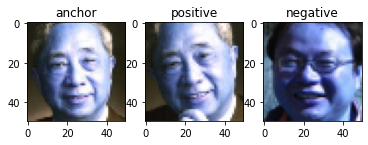

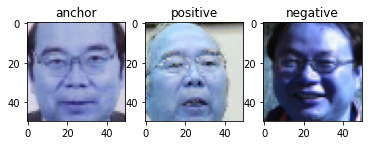

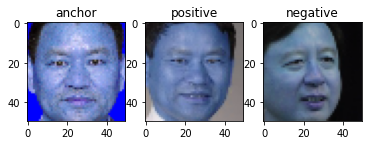

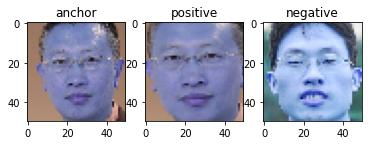

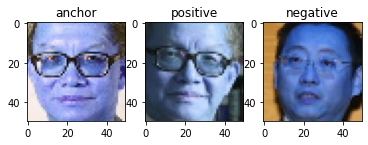

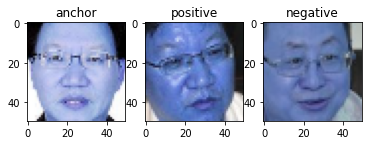

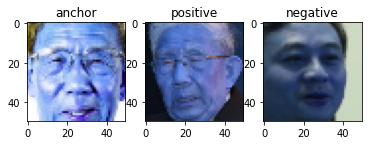

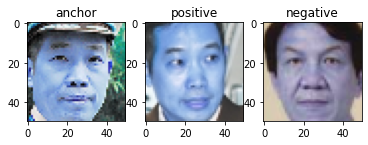

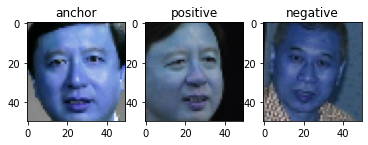

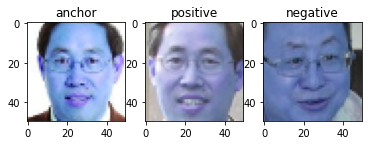

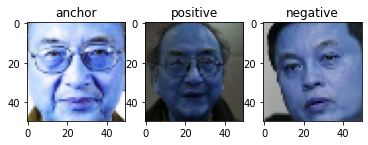

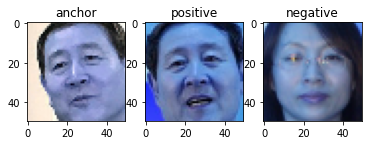

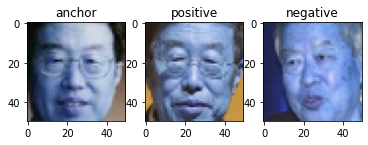

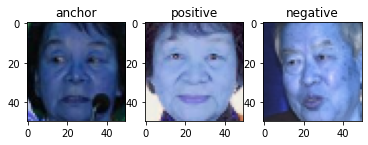

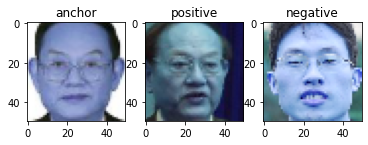

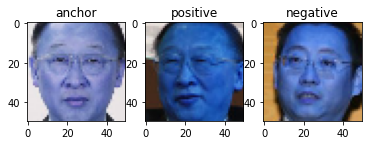

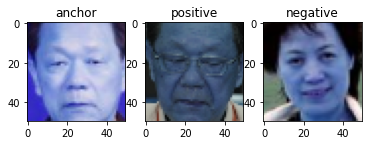

In [ ]:
for i in range(17):
  visualize(i,triplet=True)

## Triplet loss


In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Network definition

In [ ]:
class Net(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1=nn.Conv2d(3,128,3)
       self.conv2=nn.Conv2d(128,256,3)
       self.conv3=nn.Conv2d(256,352,3)
      #  self.conv3=nn.Conv2d(256,352,3)
       
       x=torch.randn(50,50,3).view(-1,3,50,50)
       self.flat=-1
       
       self.flatten(x)
       
       self.fc1=nn.Linear(self.flat,self.flat)
       self.fc2=nn.Linear(self.flat,128)
       
   def flatten(self,x):
       if(self.flat==-1):
           x=f.max_pool2d(self.conv1(x),(2,2))
           x=f.max_pool2d(self.conv2(x),(2,2))
           x=f.max_pool2d(self.conv3(x),(2,2))
           print(x[0].size())
           self.flat=x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
       print(self.flat)
       
   def forward(self,x):
       x=x.view(-1,3,50,50)
       x=f.max_pool2d(f.relu(self.conv1(x)),(2,2))
       x=f.max_pool2d(f.relu(self.conv2(x)),(2,2))
       x=f.max_pool2d(f.relu(self.conv3(x)),(2,2))
       p=x
       x=f.relu(self.fc1(x.view(-1,self.flat)))
       x=self.fc2(x)
       x = f.normalize(x,dim=-1,p=2)
      #  x=f.softmax(x,dim=1)
       return x

In [ ]:
net=Net()

torch.Size([352, 4, 4])
5632


torch.Size([2, 128])

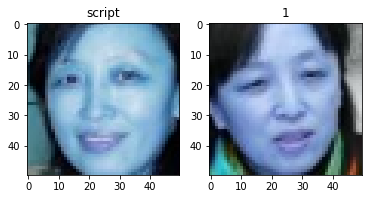

In [ ]:
images=visualize("0001_0000265")
img=torch.Tensor(list(images.values())[:3])
net.forward(img).shape

## Training


In [ ]:
device = torch.device('cuda:0')
net.to(device)


RuntimeError: ignored

In [ ]:
import torch.optim as optim
optimizer=optim.Adam(net.parameters(),lr=1e-4)
batch=500
epochs=10
training_data=[]
criterion=TripletLoss()
for i in range(0,len(triplet_data),batch):
  training_data.append(triplet_data[i:i+batch])
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, train_data in enumerate(tqdm(training_data, desc="Training", position=0, leave=False)):
        # anchor_img = anchor_img.to(device)
        # positive_img = positive_img.to(device)
        # negative_img = negative_img.to(device)
        anchor_img=[]
        positive_img=[]
        negative_img=[]
        for a,p,n in train_data:
          anchor_img.append(a)
          positive_img.append(p)
          negative_img.append(n)

        anchor_img=(torch.Tensor(anchor_img)/255).to(device)
        positive_img=(torch.Tensor(positive_img)/255).to(device)
        negative_img=(torch.Tensor(negative_img)/255).to(device)
        
        optimizer.zero_grad()
        anchor_out = net(anchor_img)
        positive_out = net(positive_img)
        negative_out = net(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

### Save model

In [ ]:
torch.save(net.state_dict(), os.path.join("/content/drive/MyDrive/Projects/Birupaksh","classes"+str(num_classes)+"neg_samp"+str(negatives_size)+"loss"+str(np.mean(running_loss))))

### Visual Evaluation

In [ ]:
# t=[]
# for a,p,n in tqdm(triplet_data[:1000]):
#   embb_a=net.forward(torch.Tensor(a).to(device))
#   embb_p=net.forward(torch.Tensor(p).to(device))
#   embb_n=net.forward(torch.Tensor(n).to(device))

#   diff_a_p=(embb_a - embb_p).pow(2).sum(1).item()
#   diff_a_n=(embb_a - embb_n).pow(2).sum(1).item()
#   t.append(diff_a_n/diff_a_p)
# print(np.min(t),np.max(t))
# print(np.argmin(t))

In [ ]:
id=509
visualize(id,triplet=True)
a,p,n=triplet_data[id]

embb_a=net.forward(torch.Tensor(a).to(device))
embb_p=net.forward(torch.Tensor(p).to(device))
embb_n=net.forward(torch.Tensor(n).to(device))

diff_a_p=(embb_a - embb_p).pow(2).sum(1)
diff_a_n=(embb_a - embb_n).pow(2).sum(1)

print("A-P: ",diff_a_p.item(),"\nA-N: ",diff_a_n.item())


In [ ]:
count=0
for i in t:
  if i<1:
    count+=1
print(count)
print(len(t))

In [ ]:
# np.add_newdoc

In [ ]:
diff_a_p=(embb_a - embb_p).pow(2).sum(1)
diff_a_n=(embb_a - embb_n).pow(2).sum(1)

print(diff_a_p,diff_a_n)

In [ ]:
l=[1,2,3,4]
l[-3:]

In [ ]:
net_test=Net()

In [ ]:
net_test.load_state_dict(torch.load("/content/drive/MyDrive/Projects/Birupaksh/classes-1neg_samp15loss2.6501377e-06",torch.device('cpu')))
# net_test.to(device)

In [ ]:
img = cv2.imread("/content/a.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.4,5)

for (x,y,w,h) in faces:
    roi = img[y:y+h, x:x+w]
    roi=cv2.resize(roi,IMAGE_SIZE)

img = cv2.imread("/content/p.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.3,5)

for (x,y,w,h) in faces:
    roi2 = img[y:y+h, x:x+w]
    roi2=cv2.resize(roi2,IMAGE_SIZE)

img = cv2.imread("/content/n.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.1,5)

for (x,y,w,h) in faces:
    roi3 = img[y:y+h, x:x+w]
    roi3=cv2.resize(roi3,IMAGE_SIZE)

roi=torch.Tensor(roi)/255
roi2=torch.Tensor(roi2)/255
roi3=torch.Tensor(roi3)/255
embb_ref=net_test(roi)
embb_pos=net_test(roi2)
embb_neg=net_test(roi3)

In [ ]:
# (ref - new).pow(2).sum(1).item()

In [ ]:
print((embb_ref - embb_pos).pow(2).sum(1).item())
print((embb_ref - embb_neg).pow(2).sum(1).item())

In [ ]:
## Above it can be seen that the positive image is closer to the reference than the negative, as seen visually below
## NOTE: 0.2 is the threshold, distance between embeddings more than it is classified as different faces

In [ ]:
visualize((roi.detach().numpy(),roi2.detach().numpy(),roi3.detach()),triplet=True)

## Results on LFW dataset

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

IMAGE_SIZE=(50,50)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

import torch
import torch.nn as nn
import torch.nn.functional as f

class Net(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1=nn.Conv2d(3,128,3)
       self.conv2=nn.Conv2d(128,256,3)
       self.conv3=nn.Conv2d(256,352,3)
      #  self.conv3=nn.Conv2d(256,352,3)
       
       x=torch.randn(50,50,3).view(-1,3,50,50)
       self.flat=-1
       
       self.flatten(x)
       
       self.fc1=nn.Linear(self.flat,self.flat)
       self.fc2=nn.Linear(self.flat,128)
       
   def flatten(self,x):
       if(self.flat==-1):
           x=f.max_pool2d(self.conv1(x),(2,2))
           x=f.max_pool2d(self.conv2(x),(2,2))
           x=f.max_pool2d(self.conv3(x),(2,2))
           print(x[0].size())
           self.flat=x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
       print(self.flat)
       
   def forward(self,x):
       x=x.view(-1,3,50,50)
       x=f.max_pool2d(f.relu(self.conv1(x)),(2,2))
       x=f.max_pool2d(f.relu(self.conv2(x)),(2,2))
       x=f.max_pool2d(f.relu(self.conv3(x)),(2,2))
       p=x
       x=f.relu(self.fc1(x.view(-1,self.flat)))
       x=self.fc2(x)
       x = f.normalize(x,dim=-1,p=2)
      #  x=f.softmax(x,dim=1)
       return x

net=Net()


torch.Size([352, 4, 4])
5632


In [ ]:
!gdown --id 1uRr-StGd_UDbLyyKBBovJZiC4cw8G3NA

Downloading...
From: https://drive.google.com/uc?id=1uRr-StGd_UDbLyyKBBovJZiC4cw8G3NA
To: /content/classes-1neg_samp15loss2.6501377e-06
134MB [00:07, 17.6MB/s]


In [ ]:
net.load_state_dict(torch.load("classes-1neg_samp15loss2.6501377e-06",torch.device('cpu')))


<All keys matched successfully>

In [ ]:
from sklearn.datasets import fetch_lfw_pairs
lfw_pairs_test = fetch_lfw_pairs(subset = 'test',color=True)
pairs = lfw_pairs_test.pairs
targets = lfw_pairs_test.target

True
False


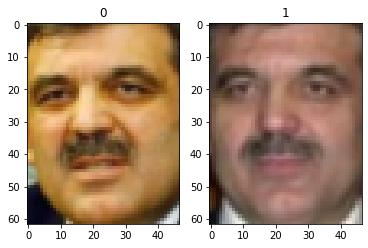

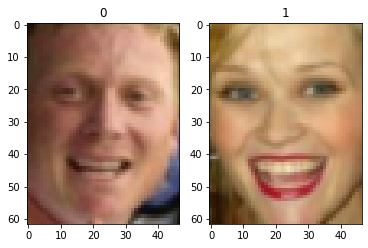

In [ ]:
indices = [0,501]
for index in indices:
  figure, axis = plt.subplots(1, 2)
  for i in range(2):
    axis[i].imshow(pairs[index][i].astype(np.uint8))
    axis[i].set_title(str(i))
  print(targets[index] == 1)
  figure.show()

In [ ]:
def compare(image_pair):
  # image_pair=image_pair.astype(np.uint16)
  # img1=cv2.cvtColor(image_pair[0], cv2.COLOR_BGR2GRAY)
  img1=cv2.resize(image_pair[0],IMAGE_SIZE)
  # img2=cv2.cvtColor(image_pair[1], cv2.COLOR_BGR2GRAY)
  img2=cv2.resize(image_pair[1],IMAGE_SIZE)
  embb1=net(torch.Tensor(img1)/255)
  embb2=net(torch.Tensor(img2)/255)
 
  dist=(embb1 - embb2).pow(2).sum(1).item()
  prediction = 1 if dist<=0.2 else 0
  return prediction

In [ ]:
TP=0 
FN=0
FP=0
TN=0
for i in tqdm(range(len(targets))):
  if targets[i]==1:
    if compare(pairs[i]) ==1:
      TP+=1
    else:
      FN+=1
  else:
    if compare(pairs[i]) ==1:
      FP+=1
    else:
      TN+=1


100%|██████████| 1000/1000 [00:37<00:00, 26.61it/s]


### Metrics

In [ ]:
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
Acc = (TP + TN) / (TP + FN + FP + TN)

print("True positive rates (or) Recall:",TPR)
print("False Positive rates:",FPR)
print("Accuracy:",Acc)

True positive rates (or) Recall: 0.798
False Positive rates: 0.518
Accuracy: 0.64


### confusion matrix

In [ ]:
print("\tPredicted True","\tPredicted False\n")
print("Actual True\t",TP,"\t",FN)
print("Actual False\t",FP,"\t",TN)

	Predicted True 	Predicted False

Actual True	 399 	 101
Actual False	 259 	 241


## Custom data face recognition

**Steps:**
1. save the images of registered people in: "data_base/people/known"
2. save the images to be recognized in: "data/people/unknown"
3. follow the code below

In [ ]:
## ignore this cell if u have run "Results on LFW dataset" block
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

IMAGE_SIZE=(50,50)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

import torch
import torch.nn as nn
import torch.nn.functional as f

class Net(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1=nn.Conv2d(3,128,3)
       self.conv2=nn.Conv2d(128,256,3)
       self.conv3=nn.Conv2d(256,352,3)
      #  self.conv3=nn.Conv2d(256,352,3)
       
       x=torch.randn(50,50,3).view(-1,3,50,50)
       self.flat=-1
       
       self.flatten(x)
       
       self.fc1=nn.Linear(self.flat,self.flat)
       self.fc2=nn.Linear(self.flat,128)
       
   def flatten(self,x):
       if(self.flat==-1):
           x=f.max_pool2d(self.conv1(x),(2,2))
           x=f.max_pool2d(self.conv2(x),(2,2))
           x=f.max_pool2d(self.conv3(x),(2,2))
           print(x[0].size())
           self.flat=x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
       print(self.flat)
       
   def forward(self,x):
       x=x.view(-1,3,50,50)
       x=f.max_pool2d(f.relu(self.conv1(x)),(2,2))
       x=f.max_pool2d(f.relu(self.conv2(x)),(2,2))
       x=f.max_pool2d(f.relu(self.conv3(x)),(2,2))
       p=x
       x=f.relu(self.fc1(x.view(-1,self.flat)))
       x=self.fc2(x)
       x = f.normalize(x,dim=-1,p=2)
      #  x=f.softmax(x,dim=1)
       return x

net=Net()
!gdown --id 1uRr-StGd_UDbLyyKBBovJZiC4cw8G3NA
net.load_state_dict(torch.load("classes-1neg_samp15loss2.6501377e-06",torch.device('cpu')))

torch.Size([352, 4, 4])
5632
Downloading...
From: https://drive.google.com/uc?id=1uRr-StGd_UDbLyyKBBovJZiC4cw8G3NA
To: /content/classes-1neg_samp15loss2.6501377e-06
134MB [00:05, 23.0MB/s]


<All keys matched successfully>

In [ ]:
def preprocess(src_path="trainset"):
  data={}
  for folder in tqdm(os.listdir(src_path)):
      dir=os.path.join(src_path,folder)
      for sub_folder in os.listdir(dir):
        count=1
        sub_dir=os.path.join(dir,sub_folder)
        for pic in (os.listdir(sub_dir)):
          path = os.path.join(sub_dir,pic)
          # print(path)
          try:
            img = cv2.imread(path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray,1.3,5)
            if len(faces)!=1:
              # print("###### ",path," multiple faces")
              continue
            for (x,y,w,h) in faces:
                roi = img[y:y+h, x:x+w]
                roi=cv2.resize(roi,IMAGE_SIZE)
            
            data[pic]= roi
          except:
            pass
            
  return data


In [ ]:
def compare(image_pair,use_embb=False,return_distance=False):
  if use_embb:
    if len(image_pair[0].shape)==3:
      img1=cv2.resize(image_pair[0],IMAGE_SIZE)
      embb1=net(torch.Tensor(img1)/255)
      embb2=image_pair[1]
    else:
      img1=cv2.resize(image_pair[1],IMAGE_SIZE)
      embb1=net(torch.Tensor(img1)/255)
      embb2=image_pair[0]
  else:
    img1=cv2.resize(image_pair[0],IMAGE_SIZE)
    img2=cv2.resize(image_pair[1],IMAGE_SIZE)
    embb1=net(torch.Tensor(img1)/255)
    embb2=net(torch.Tensor(img2)/255)
 
  dist=(embb1 - embb2).pow(2).sum(1).item()
  prediction = 1 if dist<=0.2 else 0
  if return_distance:
    return prediction,dist
  return prediction

In [ ]:
def recognize(base_embb=None,new_img_path=None,use_path=False,show_dist=False):
  Identity={}
  new_images=preprocess(new_img_path)
  if use_path!=False:
    base_embb={}
    base_images=preprocess(use_path)
    for img in base_images.keys():
      img1=cv2.resize(base_images[img],IMAGE_SIZE)
      embb1=net(torch.Tensor(img1)/255)
      base_embb[img]=embb1
  for n_key in new_images.keys():
    distance={}
    for b_key in base_embb.keys():
      _,dist=compare([base_embb[b_key],new_images[n_key]],use_embb=True,return_distance=True)
      if show_dist:
        print("###################",n_key,b_key)
        print(dist)
      distance[b_key]=dist
    Identity[n_key]=min(distance,key=distance.get)
    if min(distance.values())>0.2:
      Identity[n_key]="UNKNOWN"
  return Identity

In [ ]:
Identity=recognize(use_path="data_base",new_img_path="data")

100%|██████████| 2/2 [00:00<00:00, 26.17it/s]


In [ ]:
# !cp -r /content/trainset/0001/0001_0000255 /content/data/unknown/0001_0000255

100%|██████████| 2/2 [00:00<00:00, 25.82it/s]


Known faces


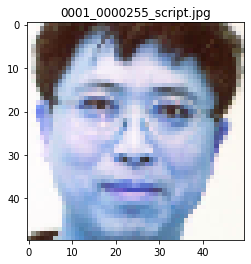

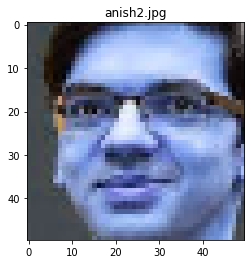

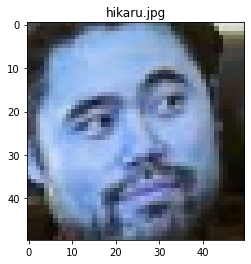

In [ ]:
data=preprocess("data")
data_base=preprocess("data_base")
unk=list(Identity.keys())
known=list(Identity.values())
print("Known faces")
for i in np.unique(known):
  if i == "UNKNOWN":
    continue
  figure, axis = plt.subplots(1, 1)

  axis.imshow(data_base[i])
  axis.set_title(i)

Unknown			 Recognition


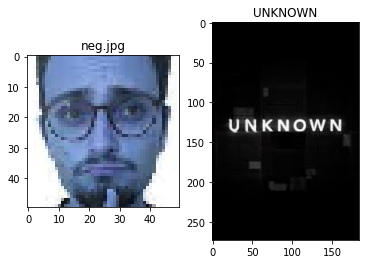

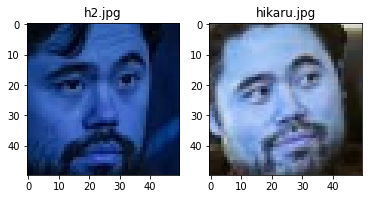

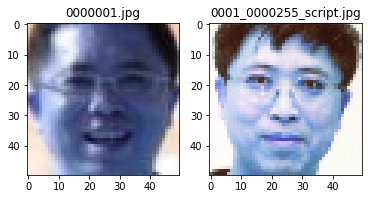

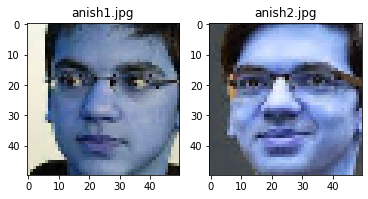

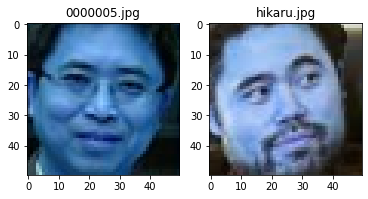

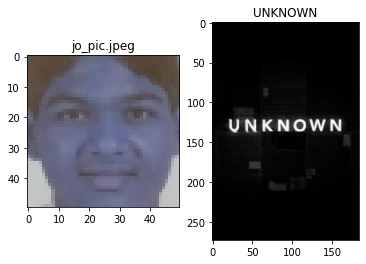

In [ ]:
print("Unknown\t\t\t Recognition")
for i in range(len(unk)):
  figure, axis = plt.subplots(1, 2)
  axis[0].imshow(data[unk[i]])
  axis[0].set_title(unk[i])
  if known[i] == "UNKNOWN":
    axis[1].imshow(cv2.imread("unknown.jpg"))
  else:
    axis[1].imshow(data_base[known[i]])
  axis[1].set_title(known[i])
  

  figure.show()

In [ ]:
Identity

{'0000001.jpg': '0001_0000255_script.jpg',
 '0000005.jpg': 'hikaru.jpg',
 'anish1.jpg': 'anish2.jpg',
 'h2.jpg': 'hikaru.jpg',
 'jo_pic.jpeg': 'UNKNOWN',
 'neg.jpg': 'UNKNOWN'}